In [1]:
import re

import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

from myPaCMAP import *

%matplotlib inline

In [2]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def low_pass_filter(data, alpha):
    """
    Apply a low-pass filter to the data using exponential moving average.
    """
    filtered_data = [data[0]]  # Initialize filtered data with the first value
    for i in range(1, len(data)):
        filtered_data.append(alpha * data[i] + (1 - alpha) * filtered_data[-1])
    return np.array(filtered_data)

def draw_results(path, mode=0, window_size=9, alpha=0.1):

    history_rewards = torch.load(os.path.join(path, "history_rewards.pt"))
    if history_rewards.device != 'cpu':
        history_rewards = history_rewards.detach().cpu()
    print(len(history_rewards))

    max_iteration = 0
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            match = re.match(r"iter(\d+)_", filename)
            if match:
                iteration = int(match.group(1))
                if iteration > max_iteration:
                    max_iteration = iteration

    iter_len = []

    for i in range(1, max_iteration+1):
        count = 0
        for filename in os.listdir(path):
            if filename.startswith("iter{}_step".format(i)):
                count += 1
        iter_len.append(count)
    print(iter_len)

    res = []
    for num in iter_len:
        subset_sum = sum(history_rewards[:num])
        try:
            res.append(subset_sum / len(history_rewards[:num]))
        except:
            print("rest: {}".format(len(history_rewards)))
        history_rewards = history_rewards[num:]

    print(len(res))

    if mode==0:
        res_avg = moving_average(res, window_size)

        plt.figure(dpi=600, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(res)

        plt.subplot(122)
        plt.plot(res_avg)

        plt.show()

    elif mode==1:
        res_avg = low_pass_filter(res, alpha=alpha)

        plt.figure(dpi=600, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(res)

        plt.subplot(122)
        plt.plot(res_avg)

        plt.show()

1440
45


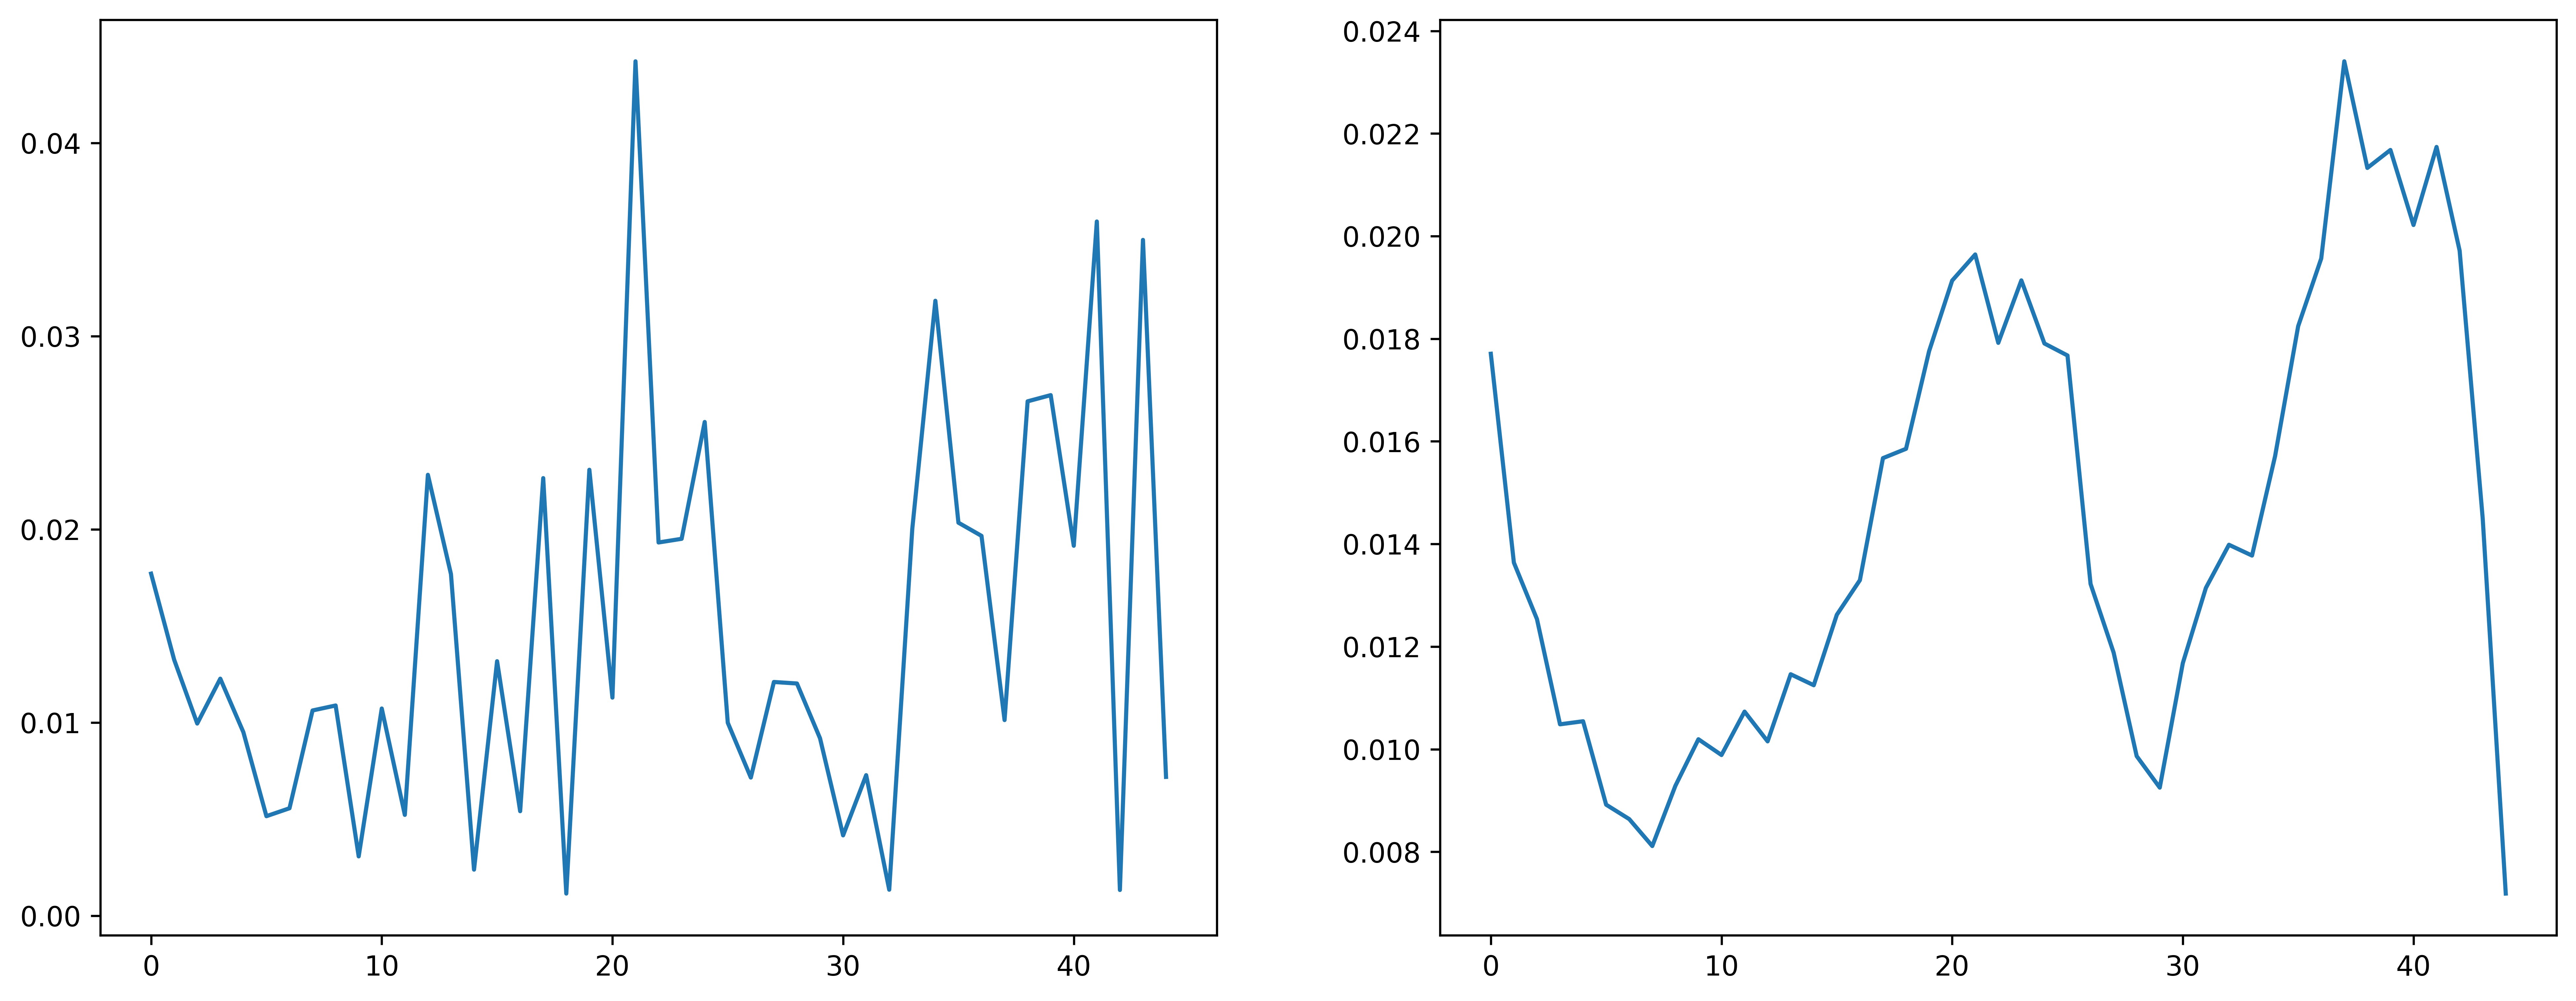

In [59]:
# 0412
draw_results(path="./runs/DVHL__ppo__0412124955__3407/", mode=0)

1440
45


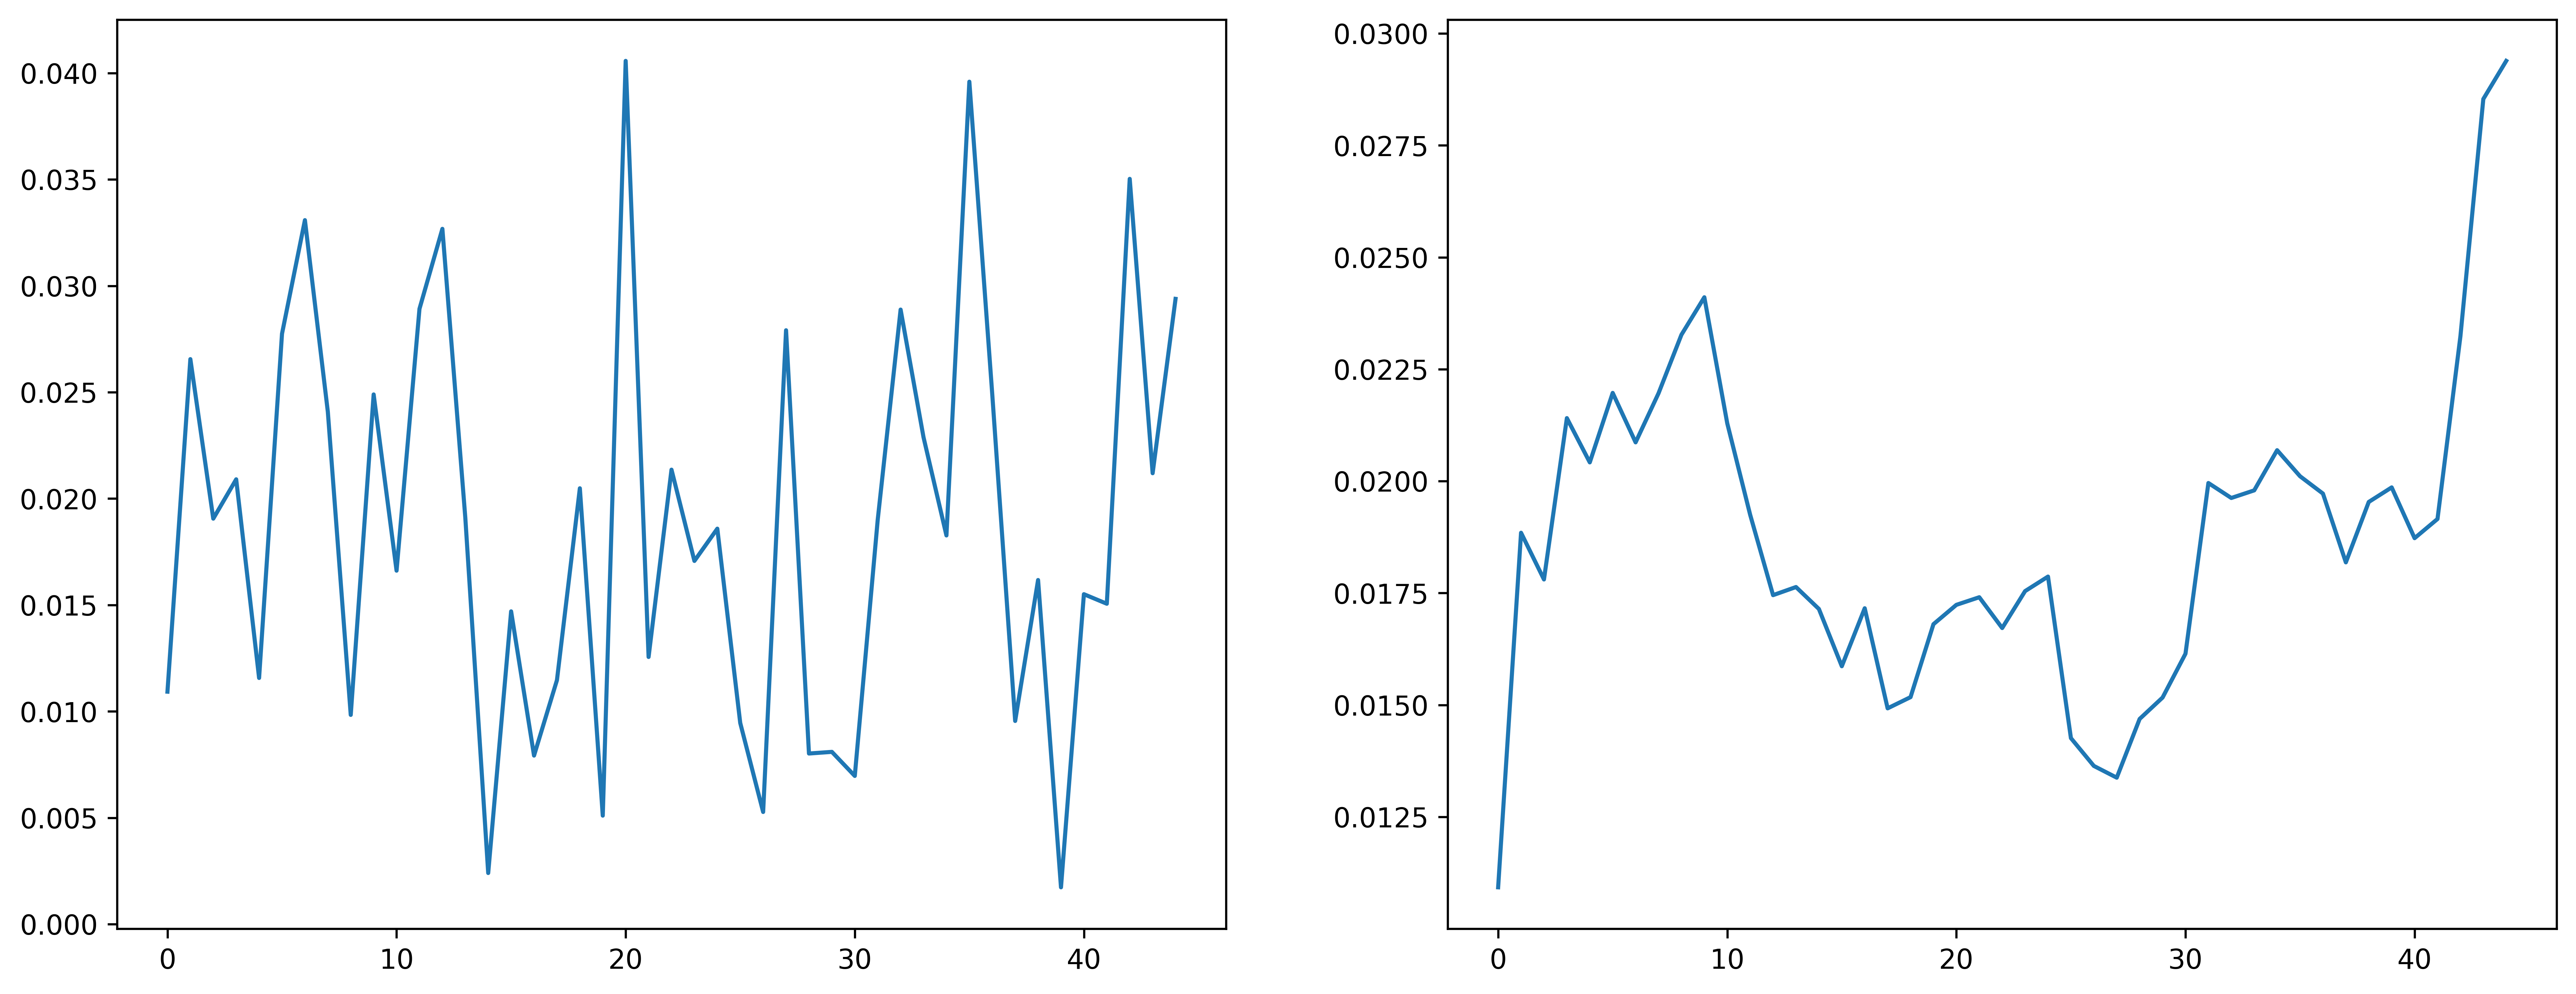

In [60]:
# 0414
draw_results(path="./runs/DVHL__ppo__0414133931__3407/", mode=0)

1403
[27, 23, 32, 23, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 32, 31, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
45


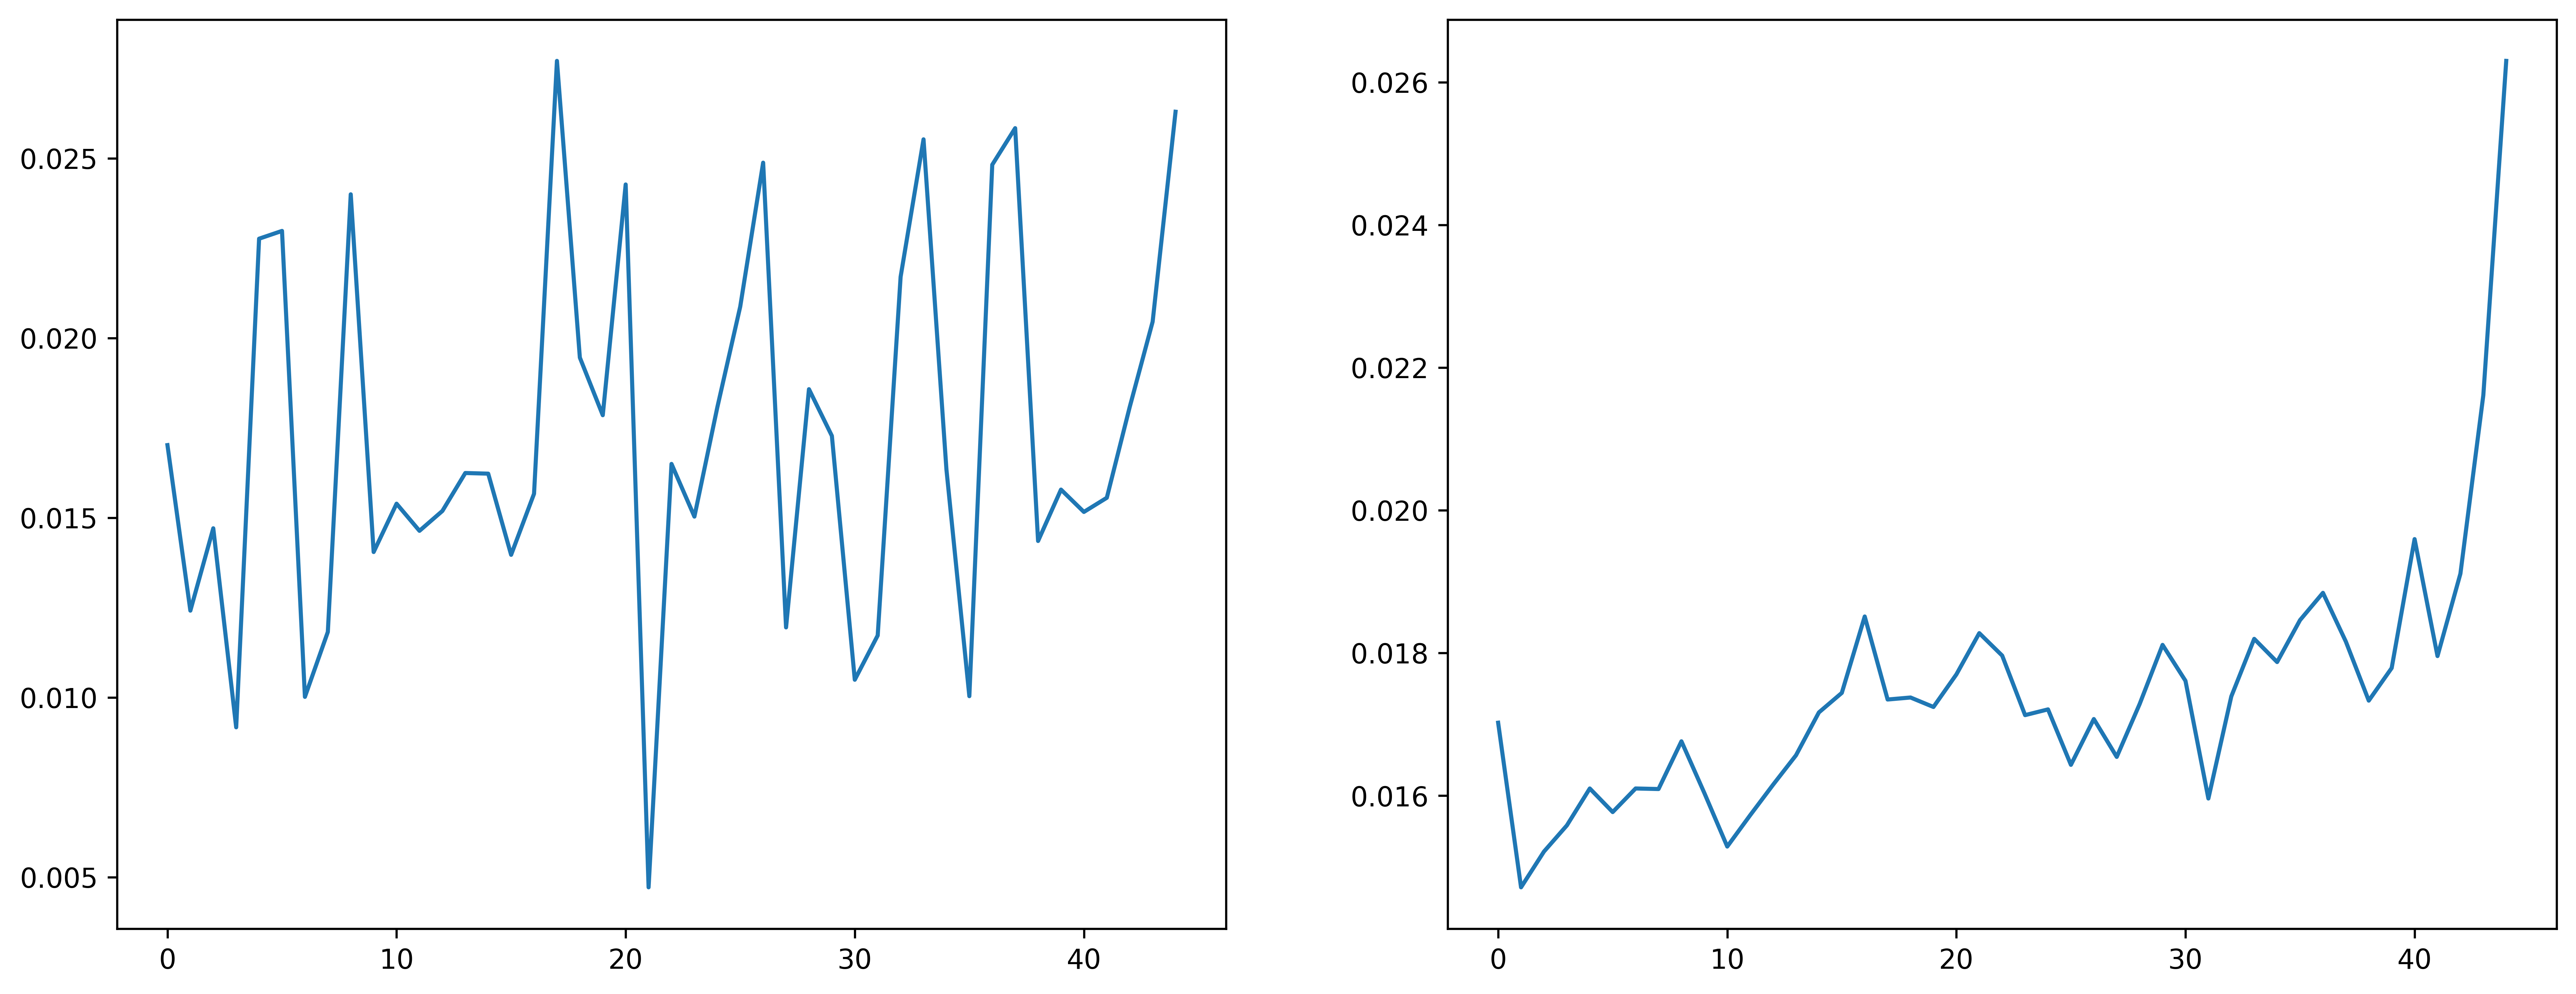

In [14]:
# 0417
draw_results(path="./runs/DVHL__ppo__0417170009__3407/", mode=0)

[['32', 'iter2'], ['32', 'iter3'], ['32', 'iter4'], ['32', 'iter5'], ['25', 'iter6'], ['32', 'iter7'], ['32', 'iter8'], ['32', 'iter9'], ['23', 'iter10'], ['31', 'iter11'], ['32', 'iter12'], ['32', 'iter13'], ['32', 'iter14'], ['32', 'iter15'], ['32', 'iter16'], ['32', 'iter17'], ['31', 'iter18'], ['32', 'iter19'], ['32', 'iter20'], ['32', 'iter21'], ['32', 'iter22'], ['32', 'iter23'], ['32', 'iter24'], ['32', 'iter25'], ['32', 'iter26'], ['32', 'iter27'], ['32', 'iter28'], ['32', 'iter29'], ['32', 'iter30'], ['23', 'iter31'], ['32', 'iter32'], ['32', 'iter33'], ['32', 'iter34'], ['32', 'iter35'], ['32', 'iter36'], ['22', 'iter37'], ['32', 'iter38'], ['32', 'iter39'], ['32', 'iter40'], ['32', 'iter41'], ['30', 'iter42']]


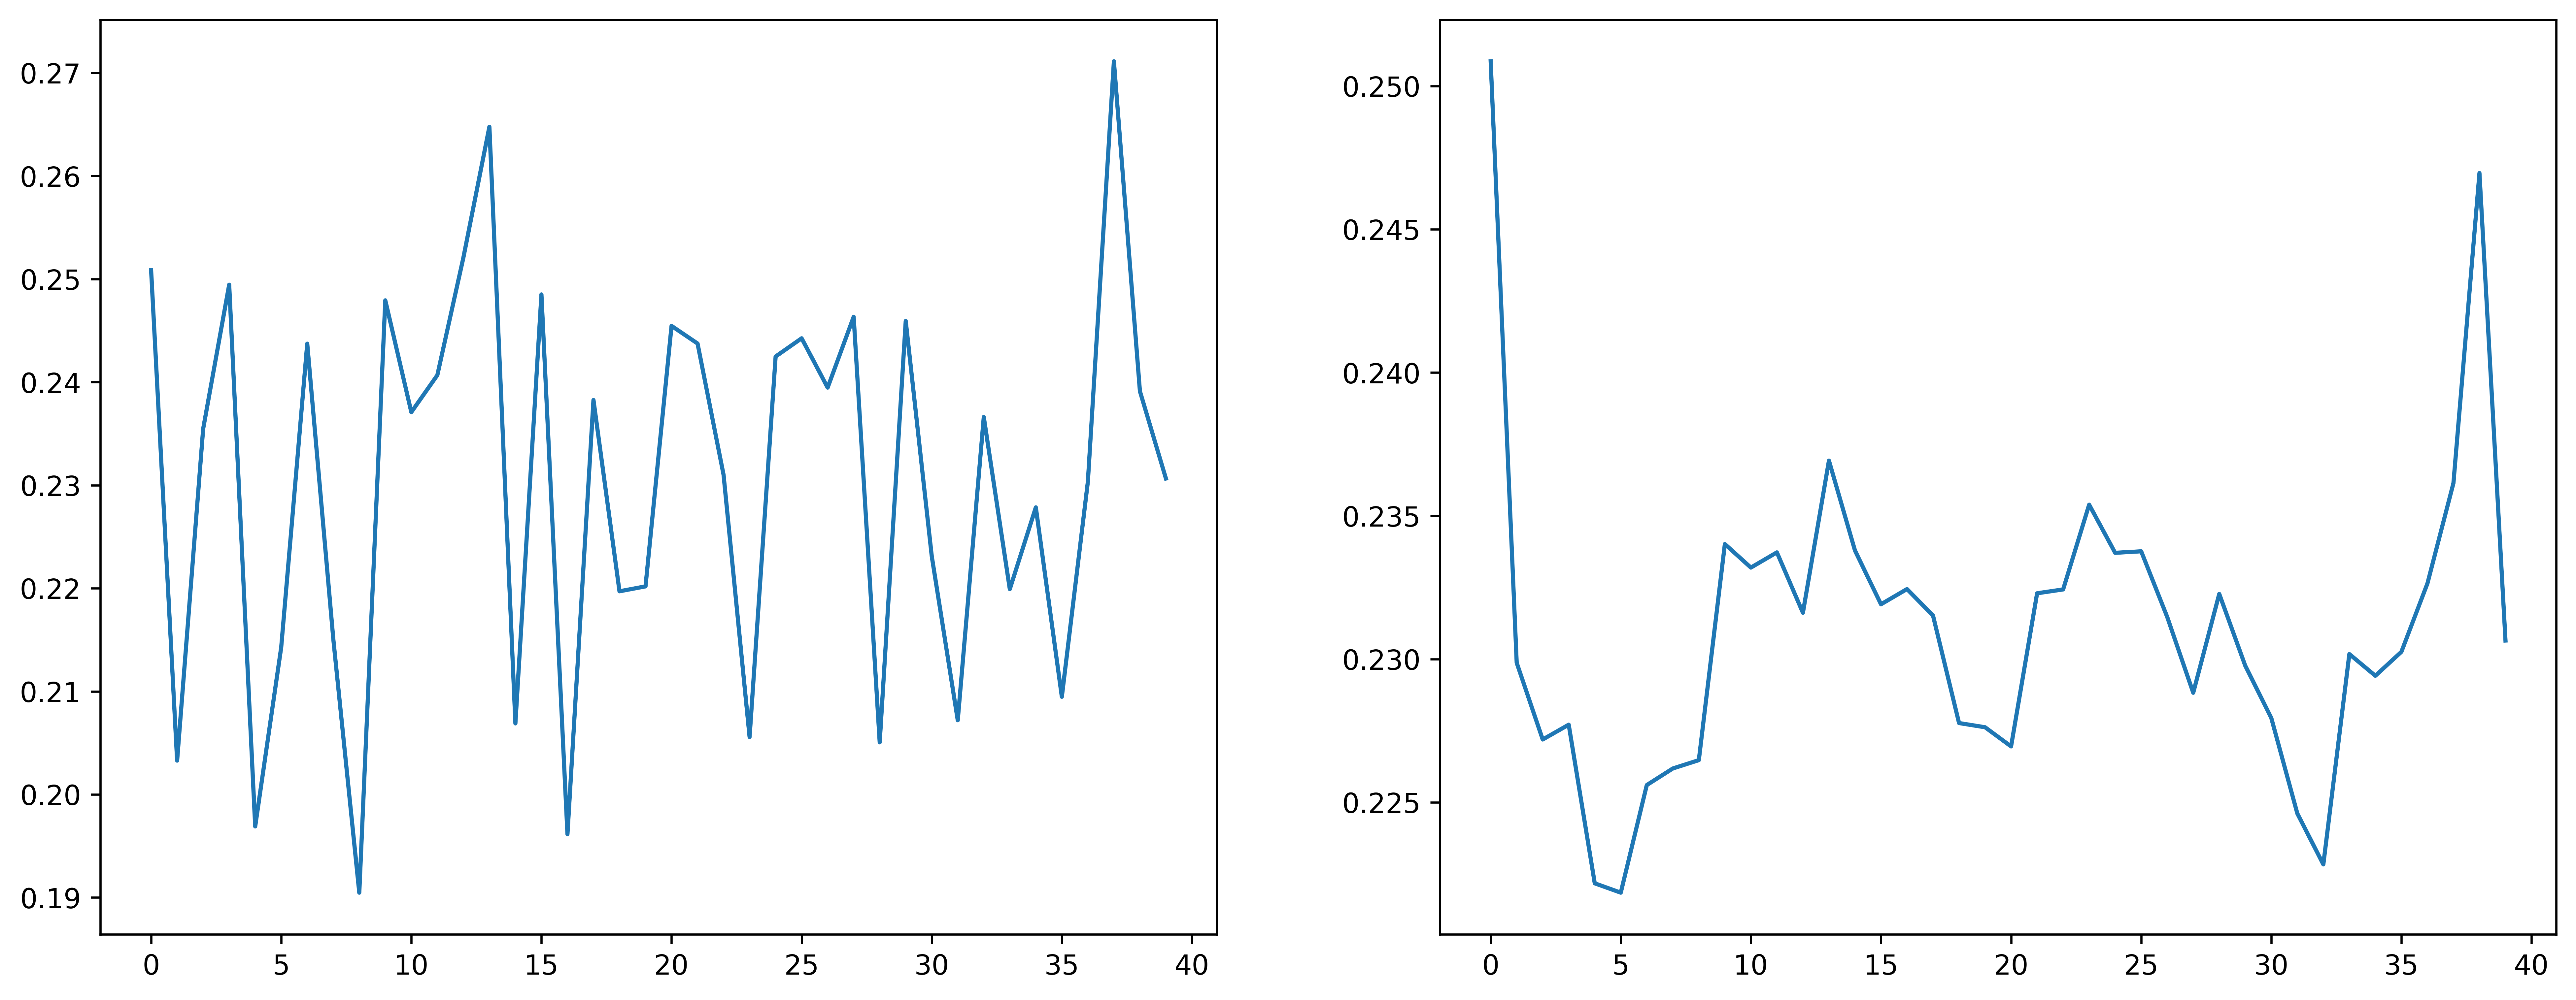

In [25]:
# 0420v1
# draw_results(path="./runs/DVHL__ppo__0417170009__3407/", mode=0)
history_rewards = torch.load("./runs/DVHL__ppo__0420104422__3407/history_rewards.pt")

# iter_len = [32, 32, 32, 32, 32, 25, 32, 32, 32]
iter_len = """32 iter1
     23 iter10
     31 iter11
     32 iter12
     32 iter13
     32 iter14
     32 iter15
     32 iter16
     32 iter17
     31 iter18
     32 iter19
     32 iter2
     32 iter20
     32 iter21
     32 iter22
     32 iter23
     32 iter24
     32 iter25
     32 iter26
     32 iter27
     32 iter28
     32 iter29
     32 iter3
     32 iter30
     23 iter31
     32 iter32
     32 iter33
     32 iter34
     32 iter35
     32 iter36
     22 iter37
     32 iter38
     32 iter39
     32 iter4
     32 iter40
     32 iter41
     30 iter42
     32 iter5
     25 iter6
     32 iter7
     32 iter8
     32 iter9
"""

iter_len = sorted([i.split() for i in iter_len.split("\n")][1:-1], key=lambda x:int(x[1][4:]))
print(iter_len)
iter_len = [int(i[0]) for i in iter_len]

res = []
for num in iter_len:
    subset_sum = sum(history_rewards[:num])
    res.append(subset_sum / len(history_rewards[:num]))
    history_rewards = history_rewards[num:]
# plt.plot(res[:-1])

res_avg = moving_average(res[:40], 9)

plt.figure(dpi=600, figsize=(16, 6))

plt.subplot(121)
plt.plot(res[:40])

plt.subplot(122)
plt.plot(res_avg)

plt.show()

In [26]:
max(res[:40])

tensor(0.2711)

1307
[32, 32, 32, 32, 32, 25, 32, 32, 32, 23, 31, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 20]
rest: 0
42


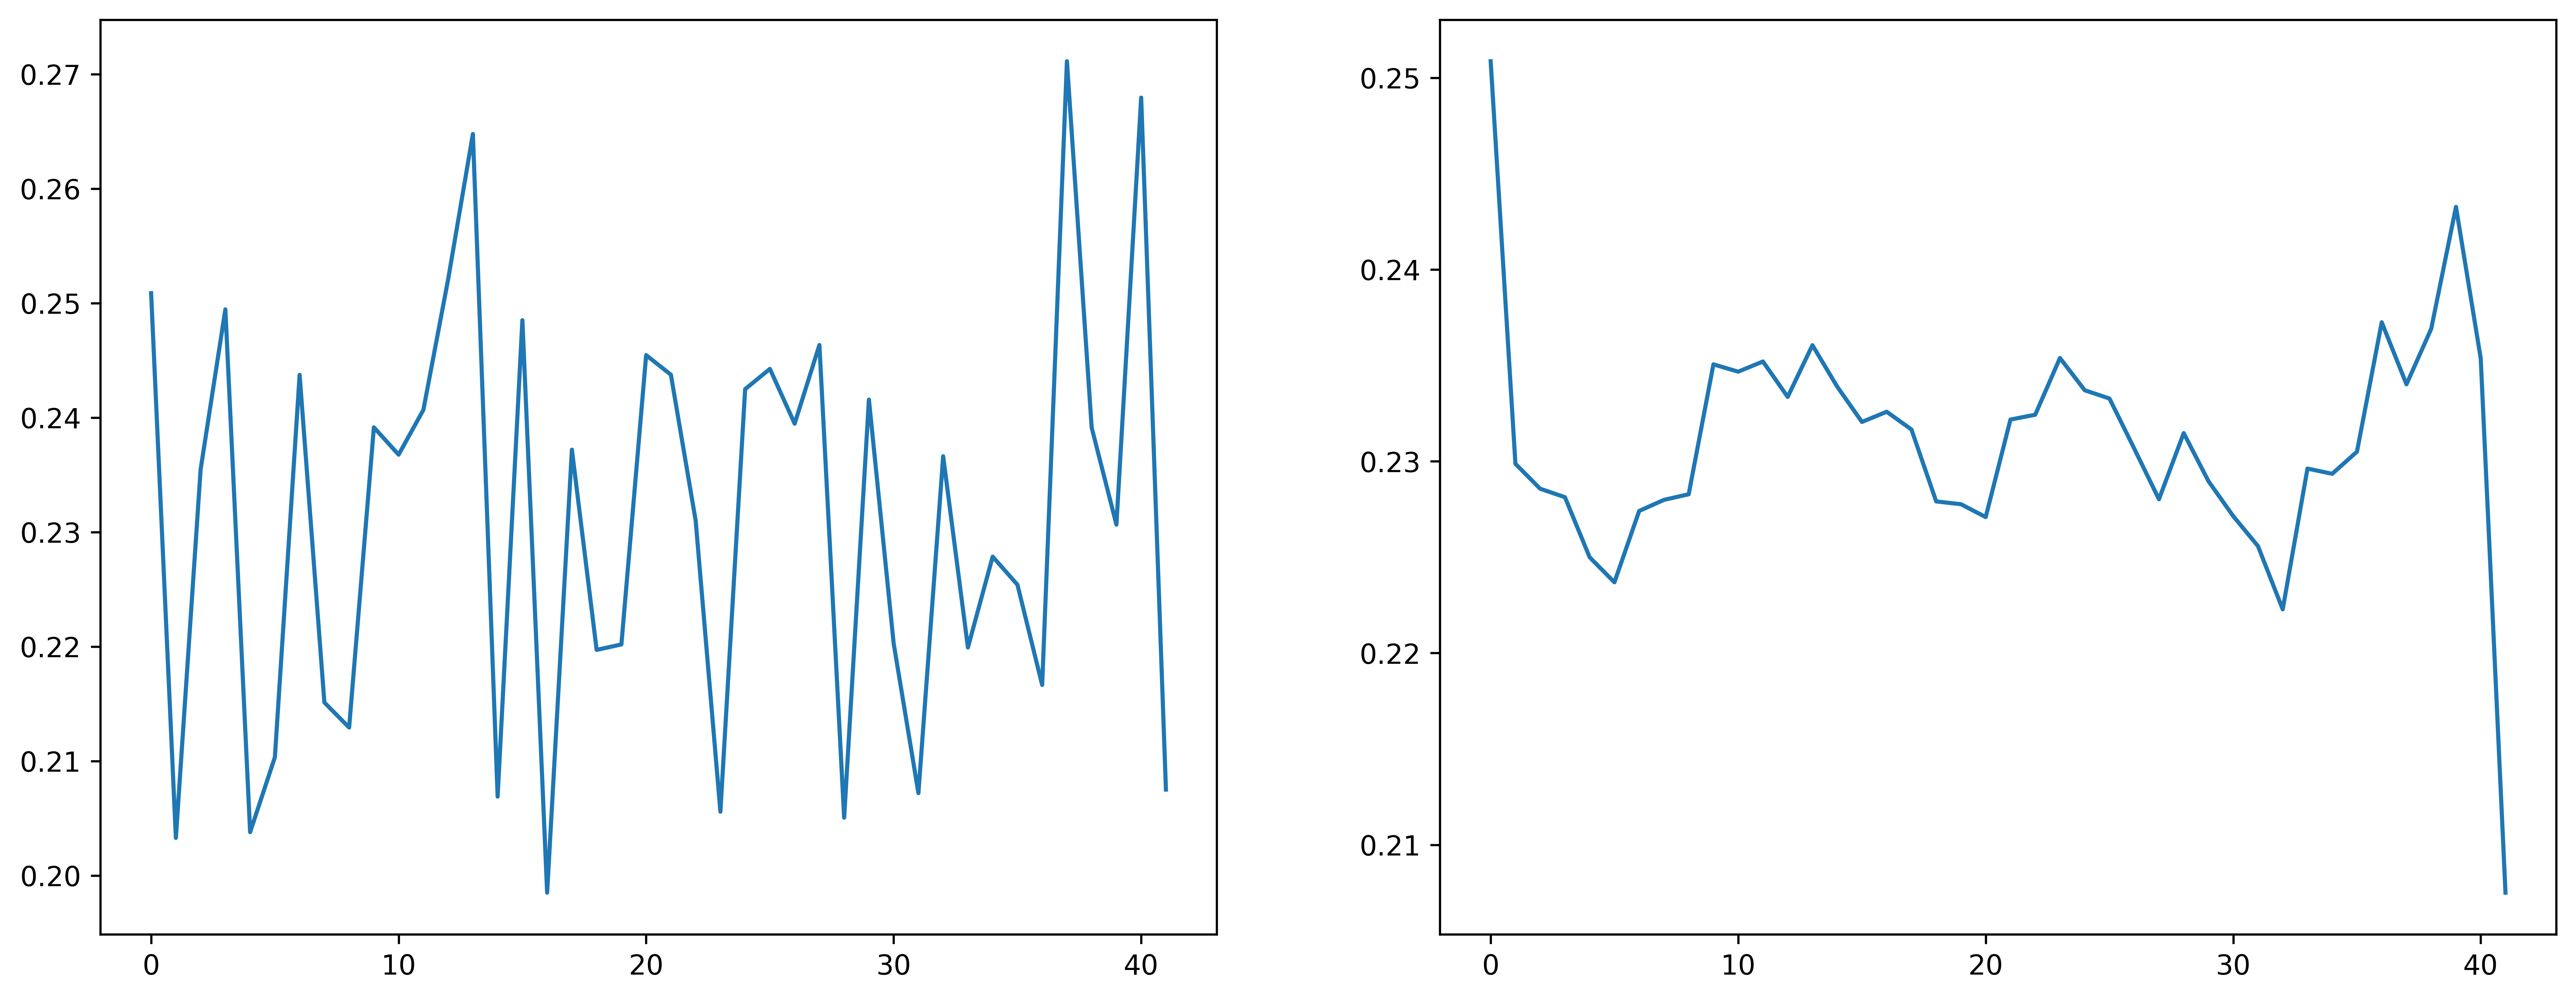

In [19]:
draw_results(path="./runs/DVHL__ppo__0420104422__3407/", mode=0)

[['32', 'iter2'], ['32', 'iter3'], ['31', 'iter4'], ['32', 'iter5'], ['28', 'iter6'], ['32', 'iter7'], ['32', 'iter8'], ['32', 'iter9'], ['32', 'iter10'], ['25', 'iter11'], ['32', 'iter12'], ['32', 'iter13'], ['25', 'iter14'], ['30', 'iter15'], ['32', 'iter16'], ['25', 'iter17'], ['32', 'iter18'], ['32', 'iter19'], ['32', 'iter20'], ['32', 'iter21'], ['32', 'iter22'], ['32', 'iter23'], ['32', 'iter24'], ['32', 'iter25'], ['32', 'iter26'], ['17', 'iter27'], ['32', 'iter28'], ['32', 'iter29'], ['32', 'iter30'], ['29', 'iter31'], ['32', 'iter32'], ['32', 'iter33'], ['32', 'iter34'], ['32', 'iter35'], ['32', 'iter36'], ['32', 'iter37'], ['32', 'iter38'], ['27', 'iter39'], ['32', 'iter40'], ['32', 'iter41'], ['27', 'iter42'], ['4', 'iter43']]


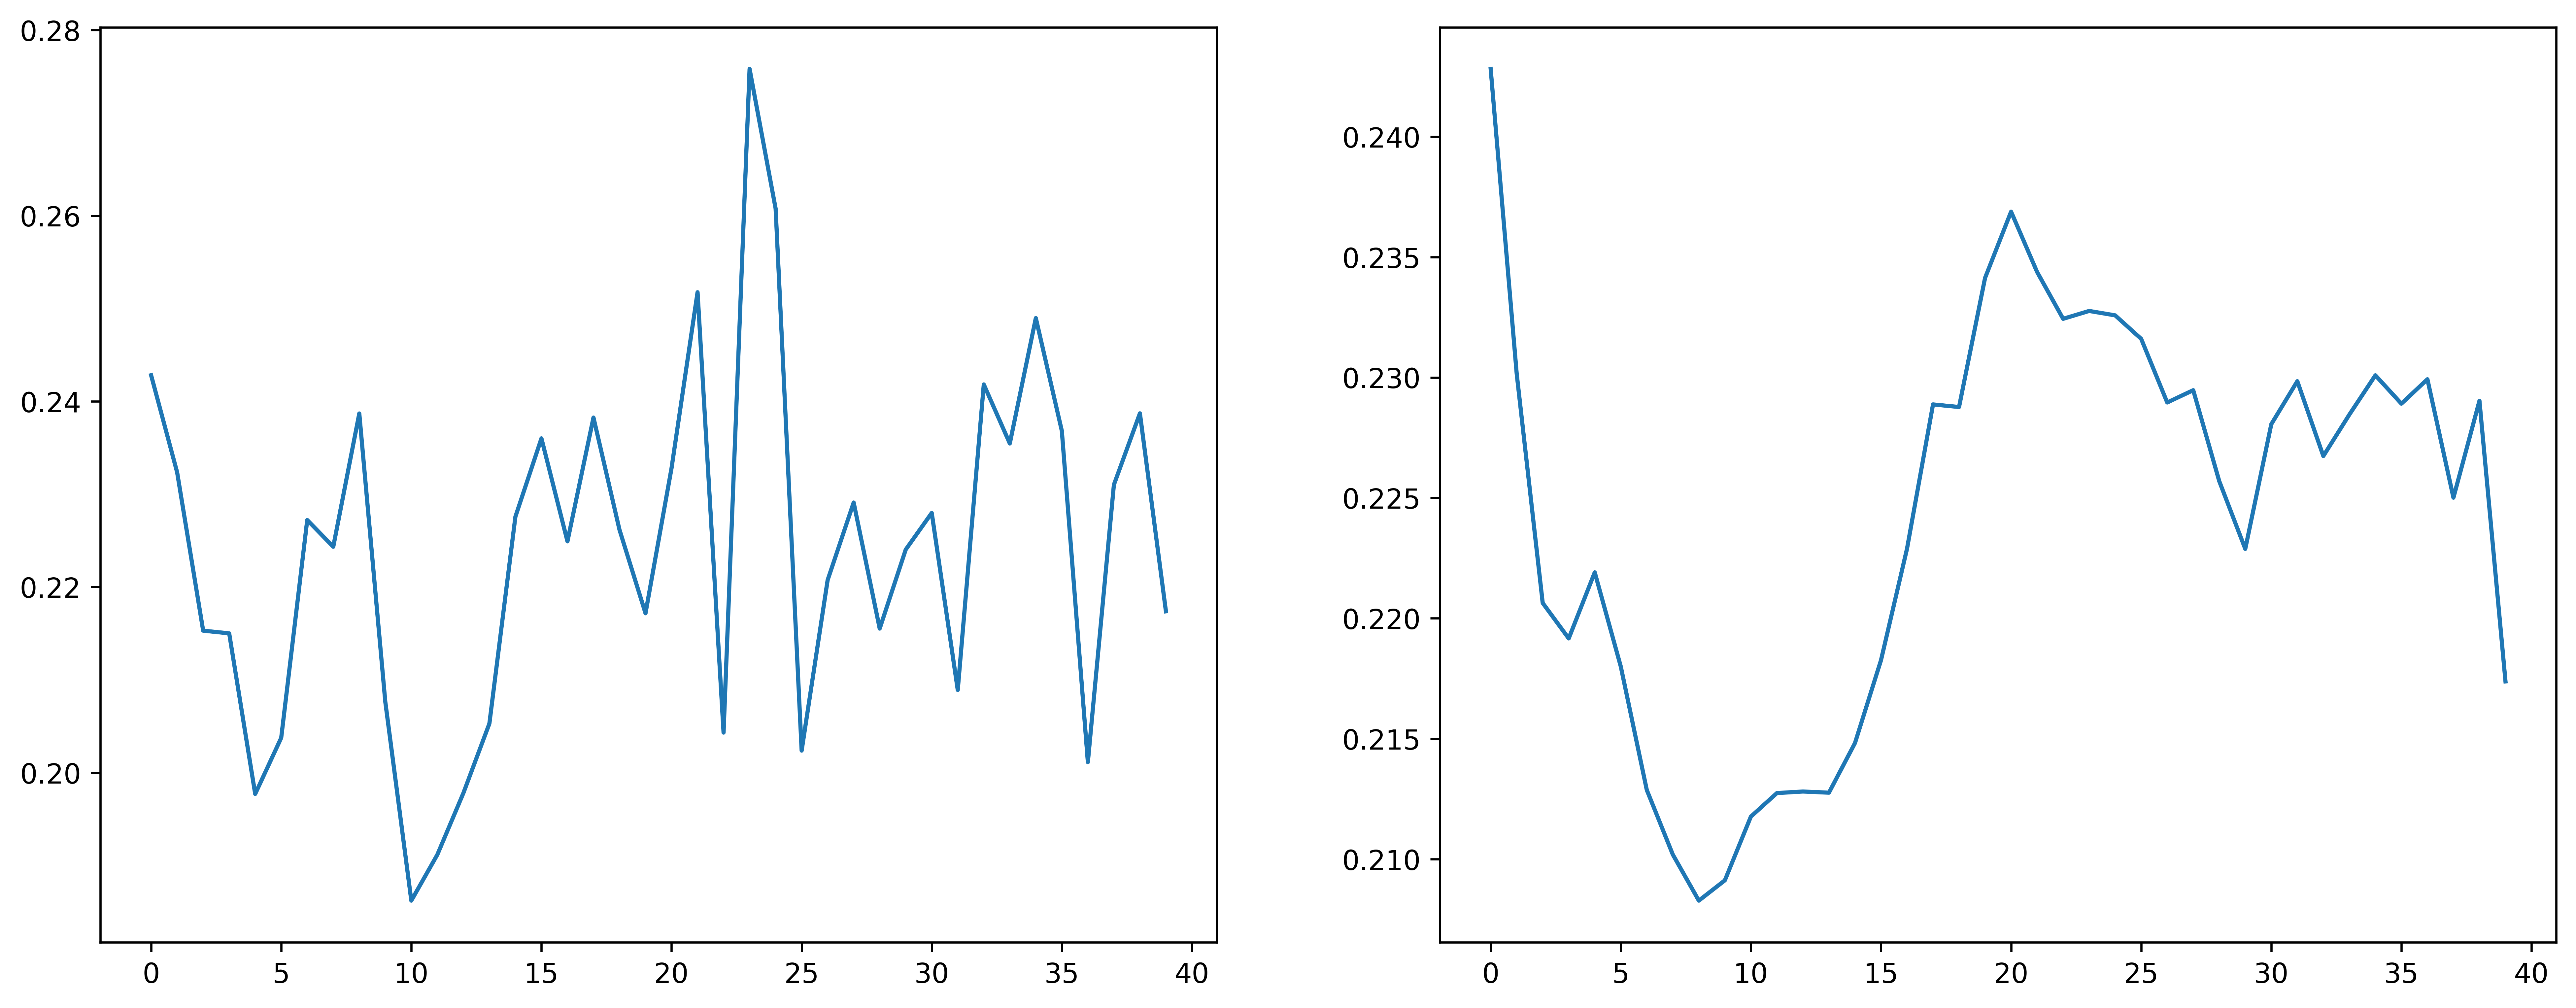

In [22]:
# 0420v2
# draw_results(path="./runs/DVHL__ppo__0417170009__3407/", mode=0)
history_rewards = torch.load("./runs/DVHL__ppo__0420104600__3407/history_rewards.pt")

# iter_len = [32, 32, 32, 31, 32, 28, 32, 32, 32, 5]
iter_len = """32 iter1
     32 iter10
     25 iter11
     32 iter12
     32 iter13
     25 iter14
     30 iter15
     32 iter16
     25 iter17
     32 iter18
     32 iter19
     32 iter2
     32 iter20
     32 iter21
     32 iter22
     32 iter23
     32 iter24
     32 iter25
     32 iter26
     17 iter27
     32 iter28
     32 iter29
     32 iter3
     32 iter30
     29 iter31
     32 iter32
     32 iter33
     32 iter34
     32 iter35
     32 iter36
     32 iter37
     32 iter38
     27 iter39
     31 iter4
     32 iter40
     32 iter41
     27 iter42
      4 iter43
     32 iter5
     28 iter6
     32 iter7
     32 iter8
     32 iter9
"""

iter_len = sorted([i.split() for i in iter_len.split("\n")][1:-1], key=lambda x:int(x[1][4:]))
print(iter_len)
iter_len = [int(i[0]) for i in iter_len]

res = []
for num in iter_len:
    subset_sum = sum(history_rewards[:num])
    res.append(subset_sum / len(history_rewards[:num]))
    history_rewards = history_rewards[num:]

# plt.plot(res[:-1])

res_avg = moving_average(res[:40], 9)

plt.figure(dpi=600, figsize=(16, 6))

plt.subplot(121)
plt.plot(res[:40])

plt.subplot(122)
plt.plot(res_avg)

plt.show()

In [23]:
max(res[:40])

tensor(0.2758)

1288
[32, 32, 32, 31, 32, 28, 32, 32, 32, 32, 25, 32, 32, 25, 30, 32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 27, 29]
rest: 0
42


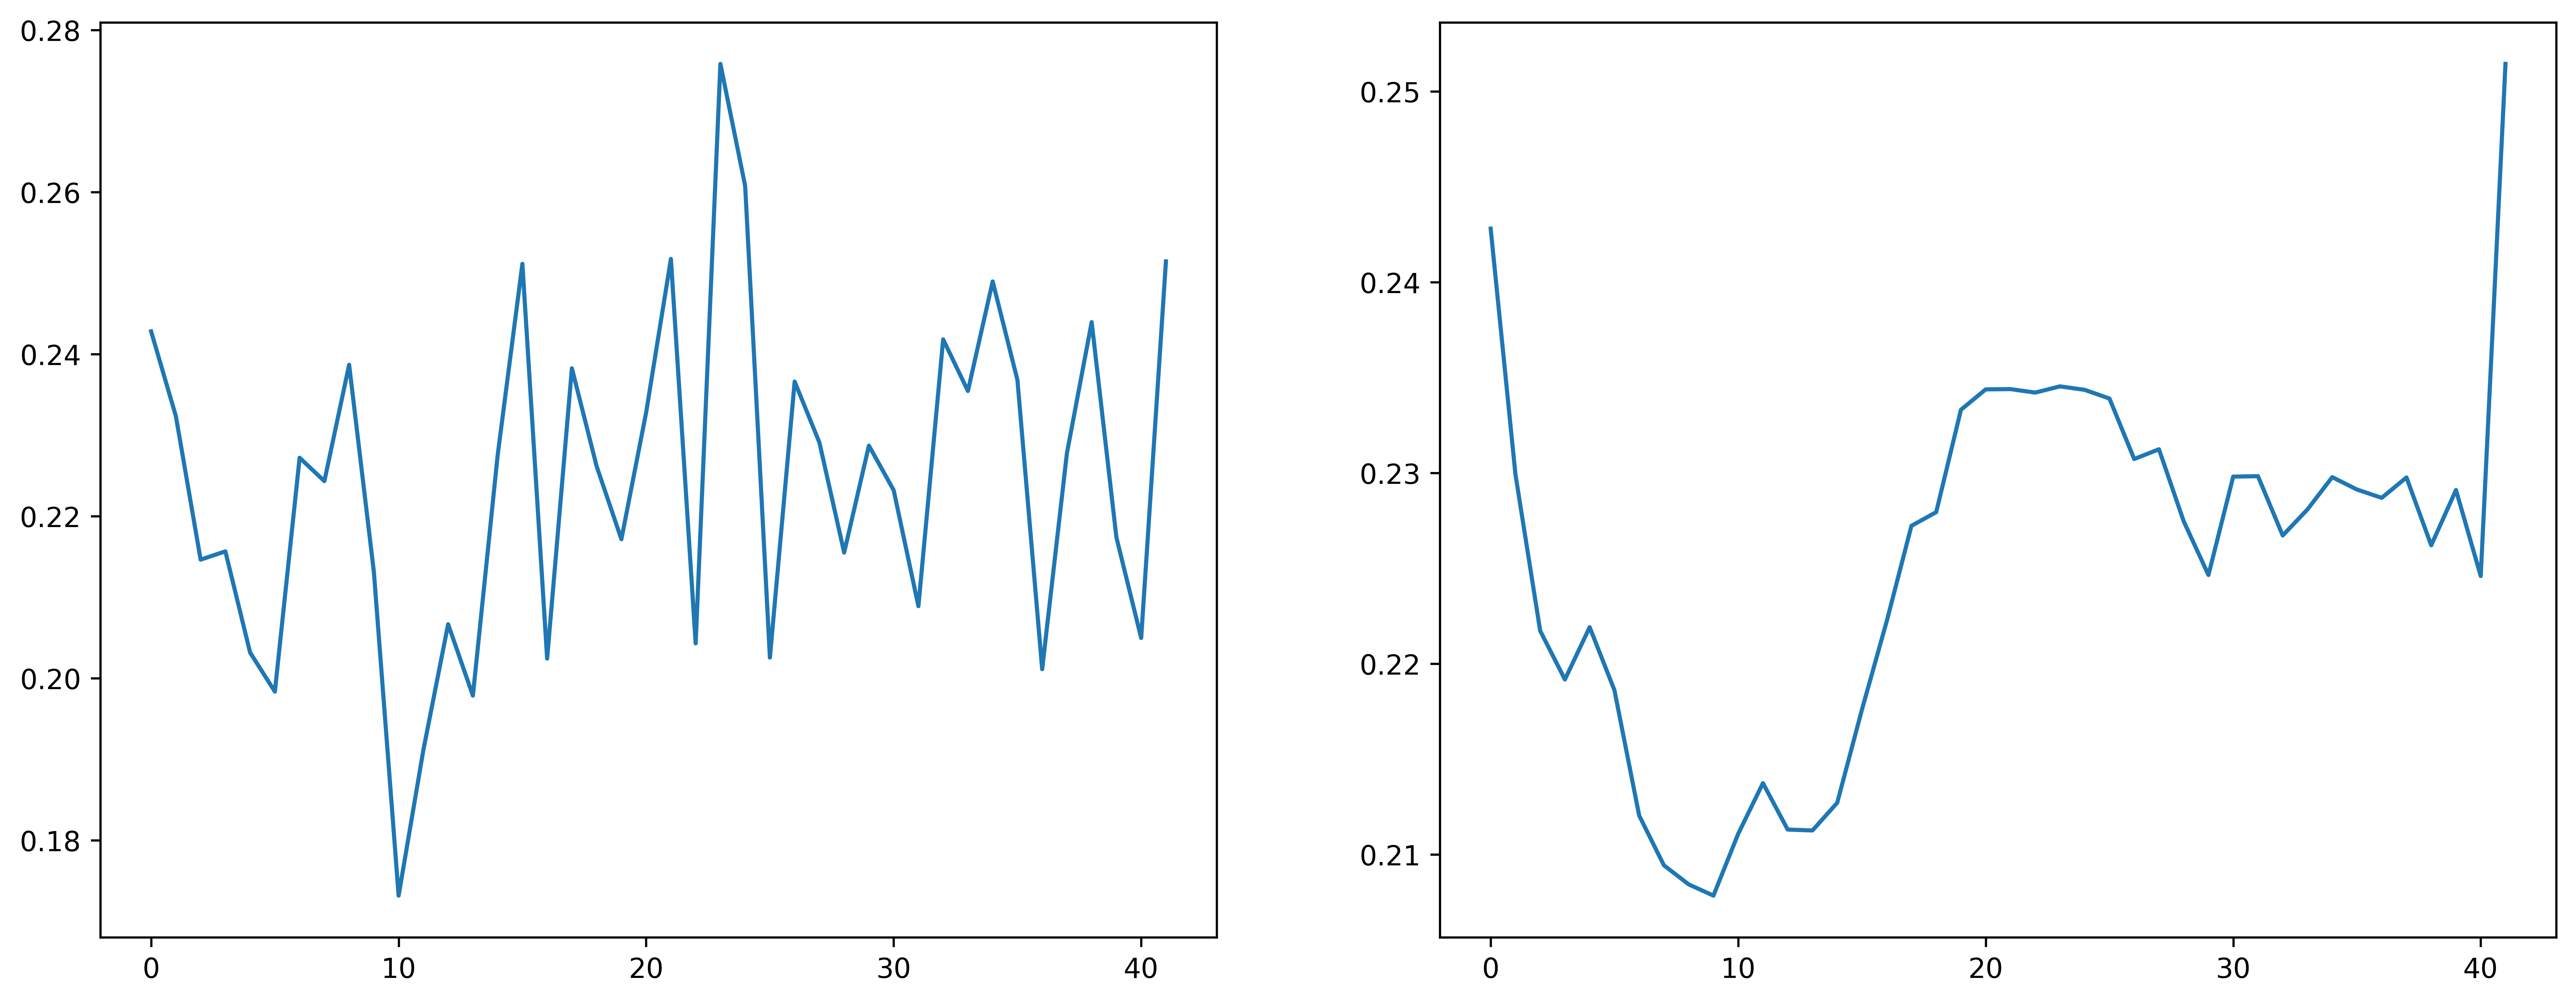

In [24]:
draw_results(path="./runs/DVHL__ppo__0420104600__3407/", mode=0)

1860
[32, 32, 32, 32, 32, 32, 20, 25, 32, 32, 32, 32, 32, 32, 25, 27, 31, 32, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 27, 32, 32, 27, 32, 30, 32, 23, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22]
rest: 0
60


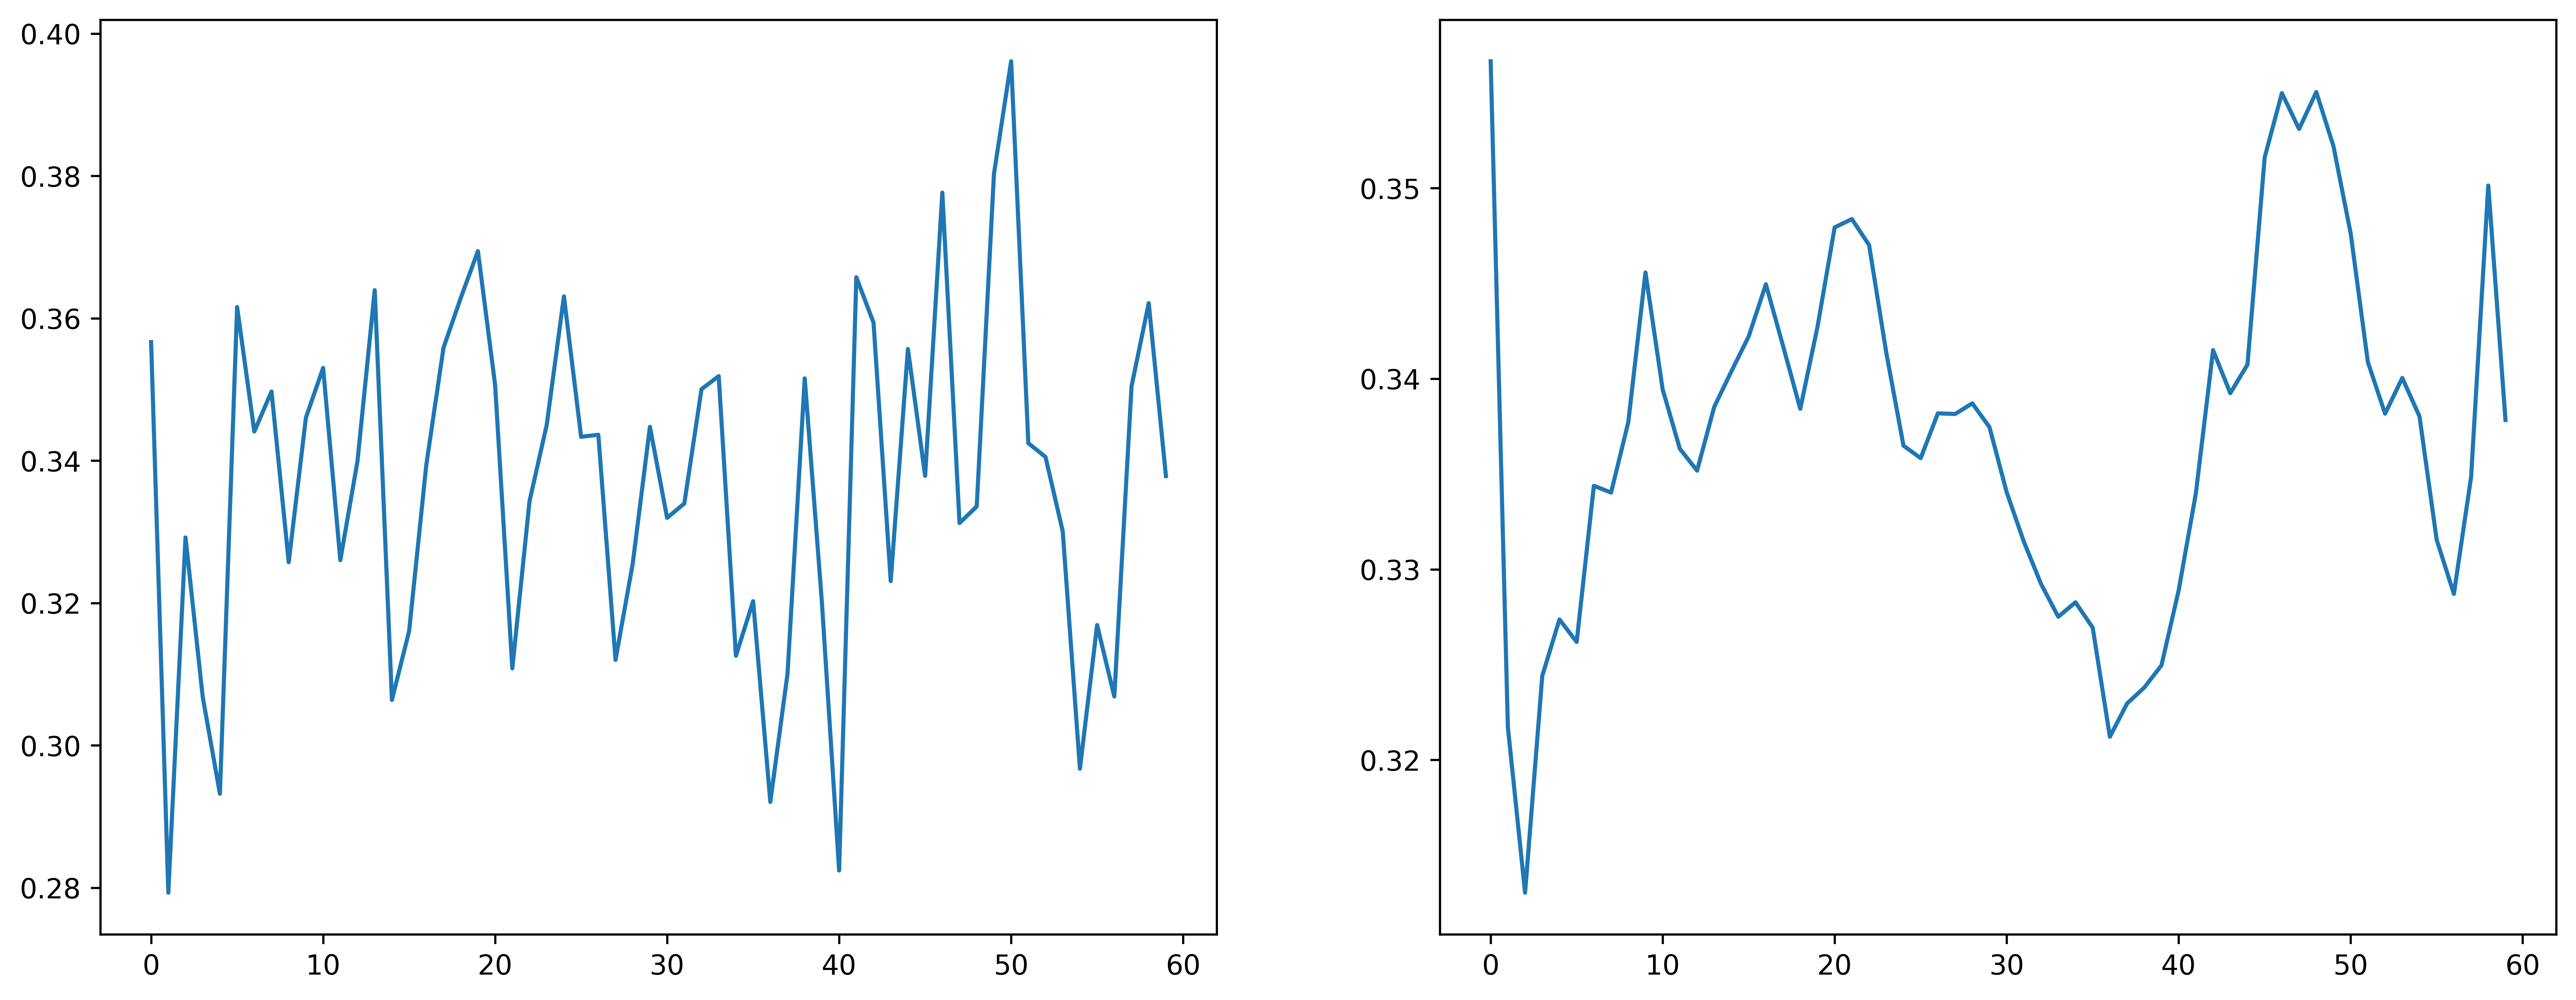

In [16]:
# 0422 + MST as reward
draw_results(path="./runs/DVHL__ppo__0422200157__3407/", mode=0)

[['32', '/iter1_png'], ['32', '/iter2_png'], ['32', '/iter3_png'], ['32', '/iter4_png'], ['32', '/iter5_png'], ['26', '/iter6_png'], ['32', '/iter7_png'], ['32', '/iter8_png'], ['32', '/iter9_png'], ['24', '/iter11_png'], ['32', '/iter12_png'], ['32', '/iter13_png'], ['32', '/iter14_png'], ['32', '/iter15_png'], ['32', '/iter16_png'], ['29', '/iter17_png'], ['32', '/iter18_png'], ['32', '/iter19_png'], ['32', '/iter20_png'], ['32', '/iter21_png'], ['32', '/iter22_png'], ['32', '/iter23_png'], ['31', '/iter24_png'], ['32', '/iter25_png'], ['24', '/iter26_png'], ['32', '/iter27_png'], ['32', '/iter28_png'], ['32', '/iter29_png'], ['32', '/iter30_png'], ['32', '/iter31_png'], ['32', '/iter32_png'], ['32', '/iter33_png']]


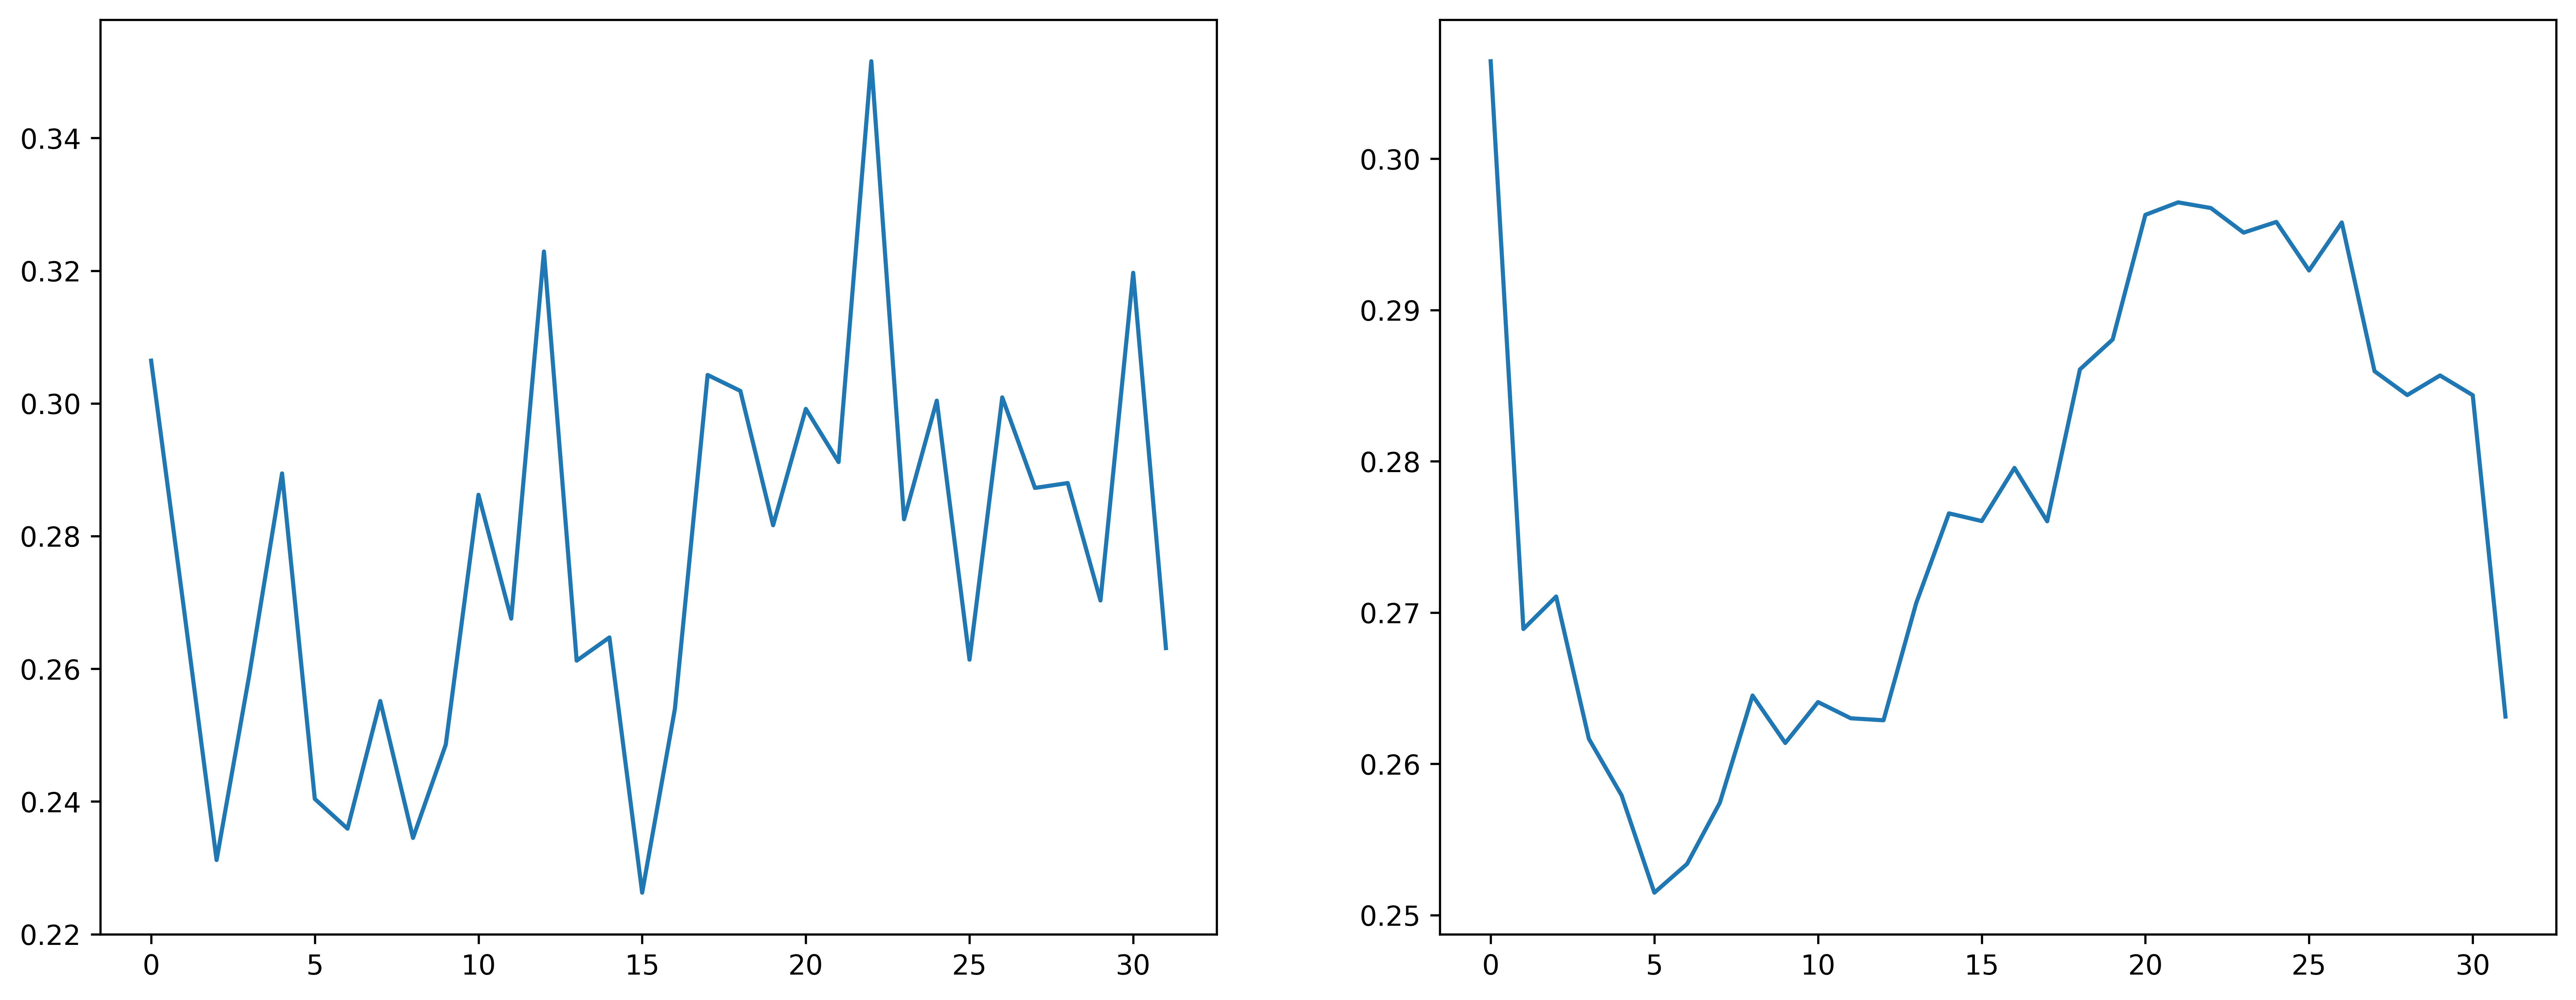

In [37]:
# 0426 newHM + newReward

history_rewards = torch.load("./runs/DVHL__ppo__0426163035__3407/history_rewards.pt")

iter_len = """      32 /iter10_png
     24 /iter11_png
     32 /iter12_png
     32 /iter13_png
     32 /iter14_png
     32 /iter15_png
     32 /iter16_png
     29 /iter17_png
     32 /iter18_png
     32 /iter19_png
     32 /iter1_png
     32 /iter20_png
     32 /iter21_png
     32 /iter22_png
     32 /iter23_png
     31 /iter24_png
     32 /iter25_png
     24 /iter26_png
     32 /iter27_png
     32 /iter28_png
     32 /iter29_png
     32 /iter2_png
     32 /iter30_png
     32 /iter31_png
     32 /iter32_png
     32 /iter33_png
     32 /iter3_png
     32 /iter4_png
     32 /iter5_png
     26 /iter6_png
     32 /iter7_png
     32 /iter8_png
     32 /iter9_png
"""

iter_len = sorted([i.split() for i in iter_len.split("\n")][1:-1], key=lambda x:int(x[1].split("_")[0][5:]))
print(iter_len)
iter_len = [int(i[0]) for i in iter_len]

res = []
for num in iter_len:
    subset_sum = sum(history_rewards[:num])
    res.append(subset_sum / len(history_rewards[:num]))
    history_rewards = history_rewards[num:]
# plt.plot(res[:-1])

res_avg = moving_average(res[:33], 9)

plt.figure(dpi=600, figsize=(16, 6))

plt.subplot(121)
plt.plot(res[:40])

plt.subplot(122)
plt.plot(res_avg)

plt.show()

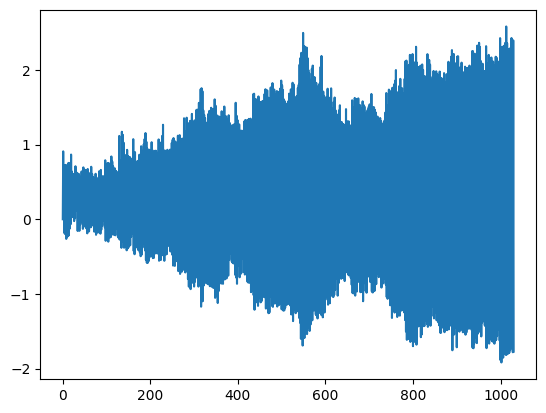

In [12]:
plt.plot(rewards)

1687
[32, 32, 32, 32, 32, 32, 32, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 30, 32, 28, 28, 32, 32, 32, 31, 25, 24]
rest: 0
54


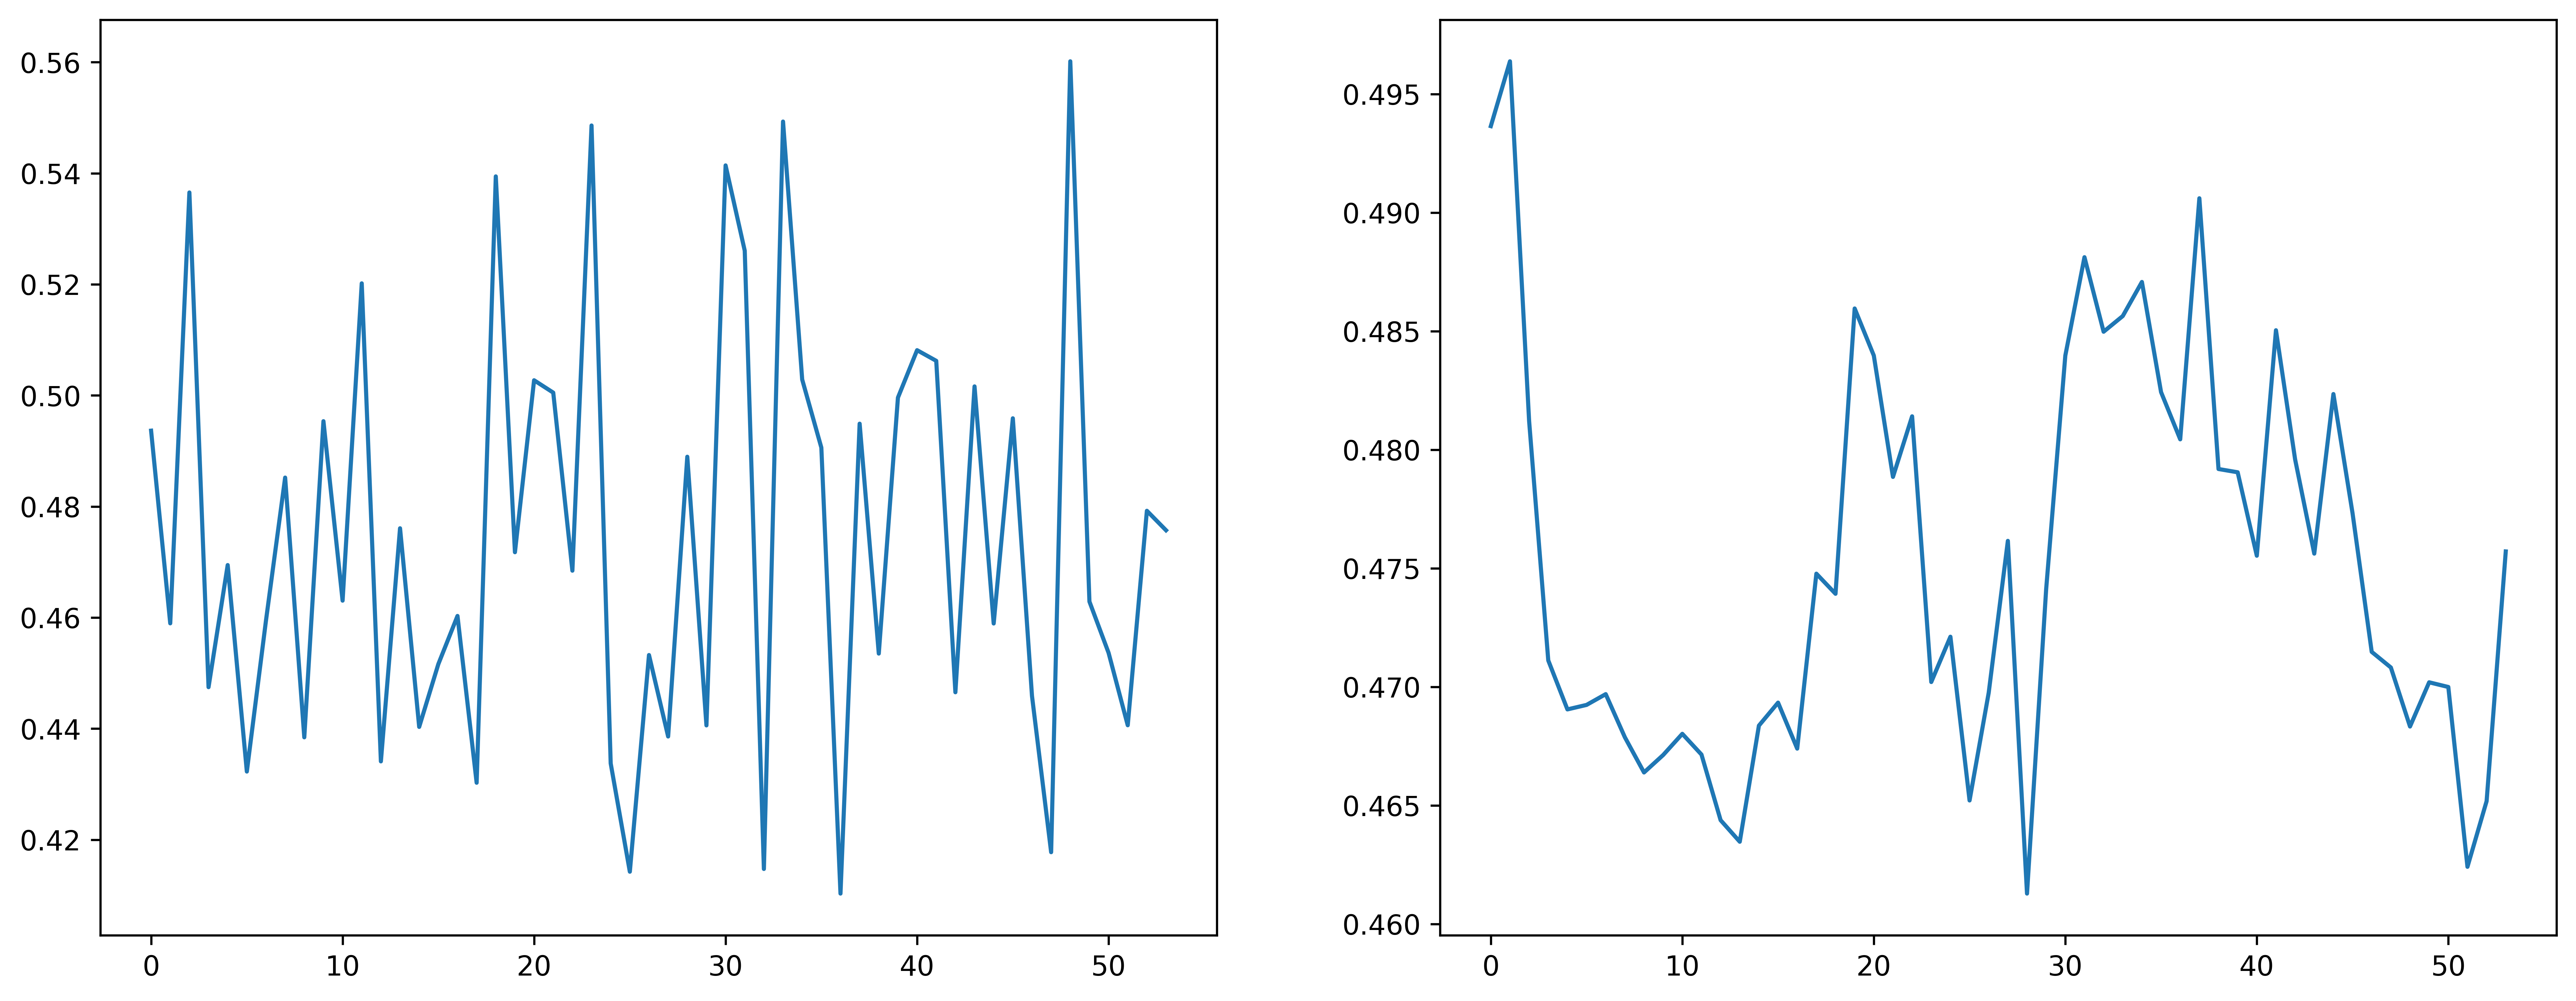

In [3]:
# 0425
# new HM surrogate
draw_results(path="./runs/DVHL__ppo__0425110953__3407/", mode=0)

1339
[27, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 26, 28, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 30, 32, 31, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 5]
44


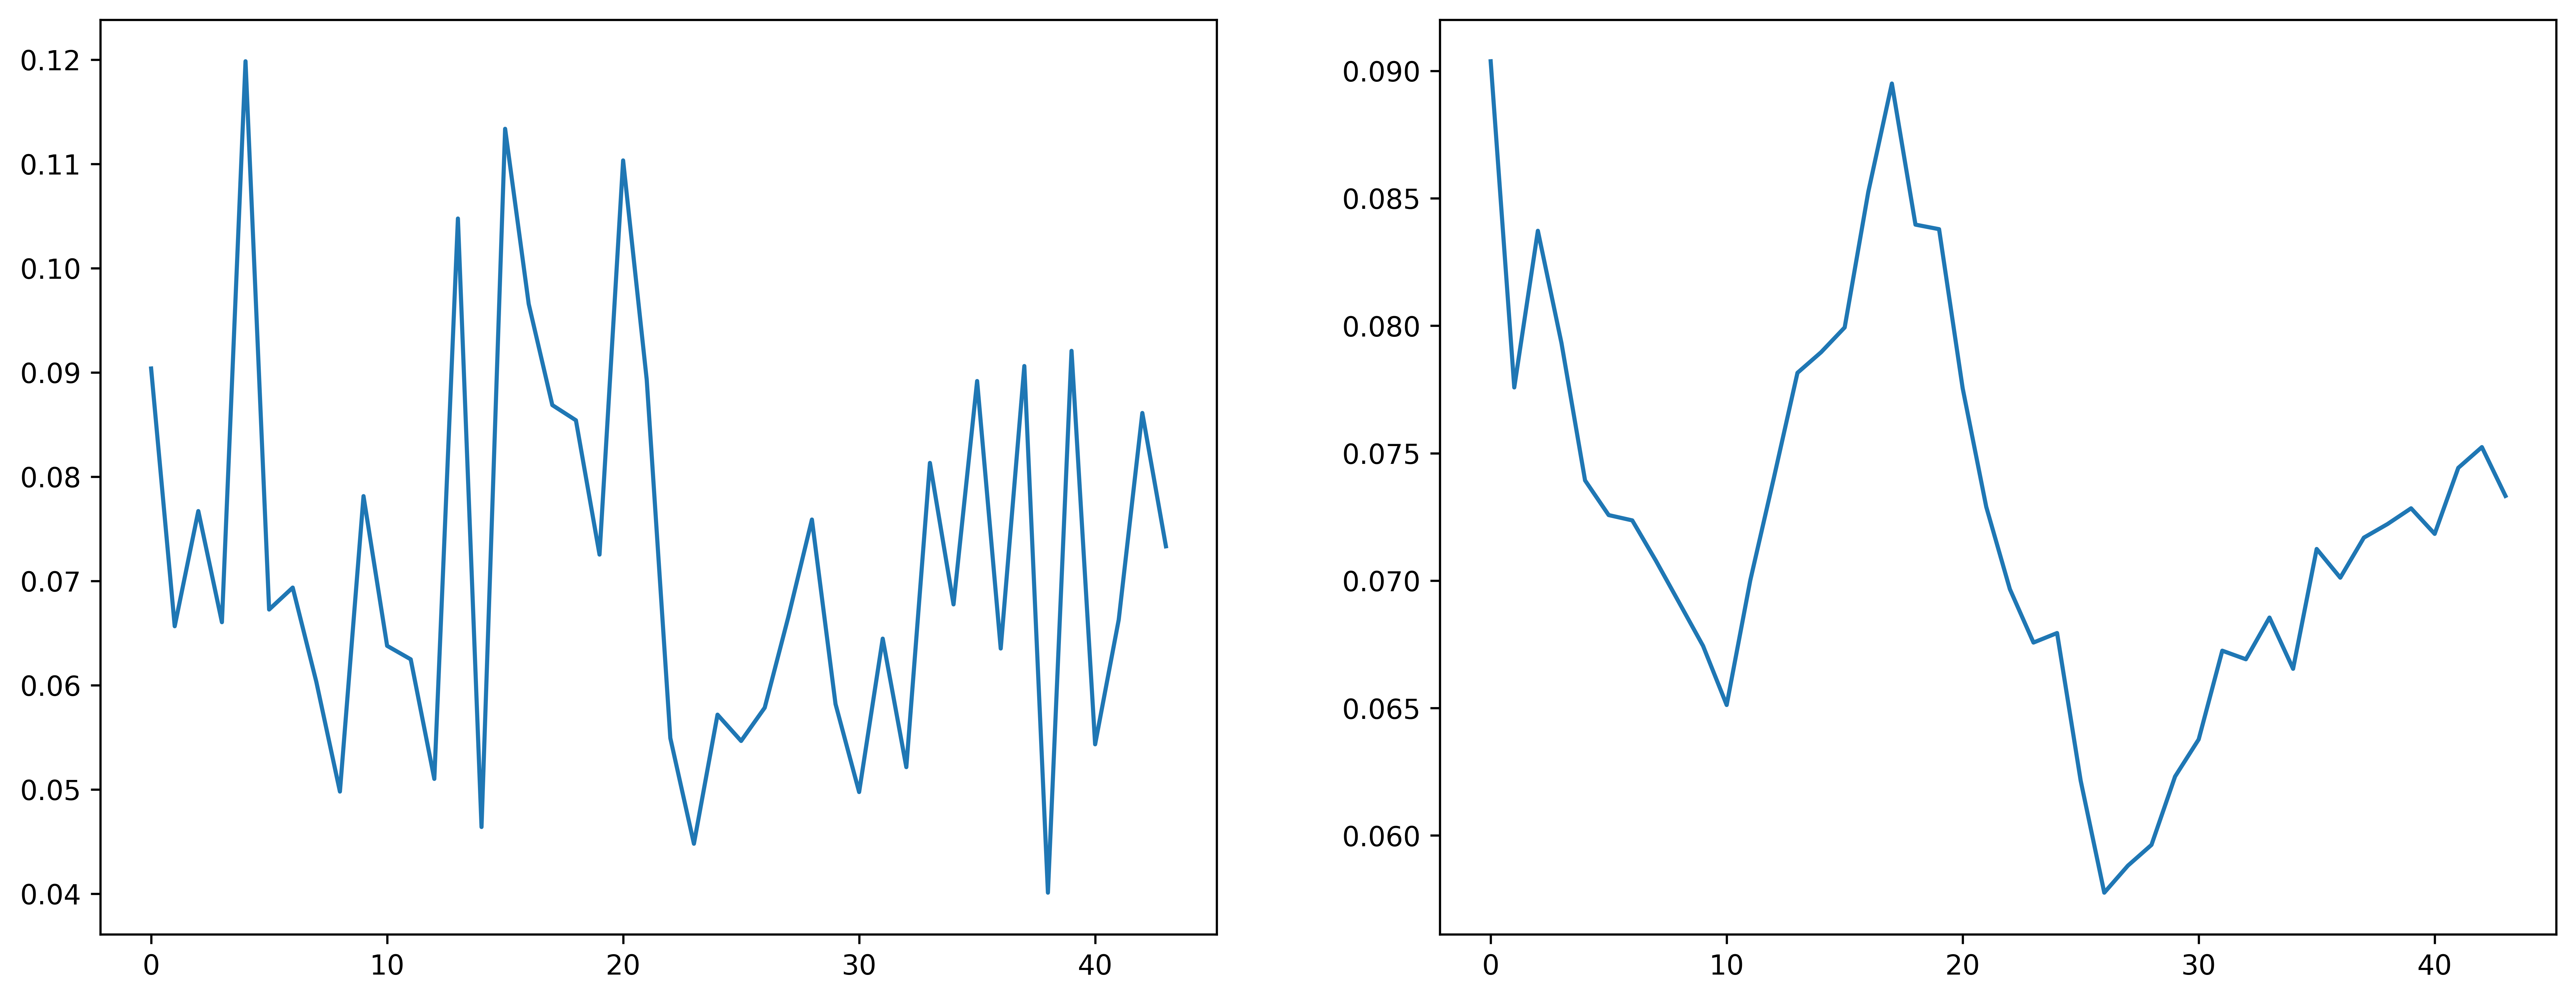

In [4]:
# 0427
# new HM surrogate + new r3

draw_results(path="./runs/DVHL__ppo__0427164950__3407/", mode=0)